In [11]:
import os
import cv2
import pydicom
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [12]:
# # dcm 이미지 png로 저장
# dcm_dir = "./dcm"
# img_dir = "./png"
# dcm_file_list = os.listdir(dcm_dir)
 
# for i, file in enumerate(dcm_file_list):
#     dcm_path = dcm_dir+"/"+file
#     ds = pydicom.dcmread(dcm_path)
#     pil_img = Image.fromarray(ds.pixel_array)
    
#     img_path = img_dir+"/img_"+str(i)+".png"
#     pil_img.save(img_path)
    
#     src = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     dst = cv2.resize(src, (512,512))
    
#     cv2.imwrite(img_path, dst)

In [13]:
# #dcm 이미지 png로 저장
# # test 이미지
# dcm_test_dir = "./dcm_test"
# img_test_dir = "./png_test"
# dcm_test_file_list = os.listdir(dcm_test_dir)
 
# for i, file in enumerate(dcm_test_file_list):
#     dcm_test_path = dcm_test_dir+"/"+file
#     ds = pydicom.dcmread(dcm_test_path)
#     pil_img = Image.fromarray(ds.pixel_array)
    
#     img_test_path = img_test_dir+"/img_"+str(i)+".png"
#     pil_img.save(img_test_path)
    
#     src = cv2.imread(img_test_path, cv2.IMREAD_GRAYSCALE)
#     dst = cv2.resize(src, (512,512))
    
#     cv2.imwrite(img_test_path, dst)

In [14]:
# input 이미지의 평균 밝기와 대비를 계산함
def compute_brightness_contrast(image):
    brightness = np.mean(image)
    contrast = np.std(image)
    return brightness, contrast

In [15]:
# 이미지가 환하게 나와서 대비를 향상시킴
def increase_contrast(img):
    min_val = np.min(img)
    max_val = np.max(img)
    stretched = (img - min_val) / (max_val - min_val) * 255
    return stretched.astype(np.uint8)

In [16]:
# 1차원 배열의 인덱스를 2차원 좌표로 변환함
def index_to_coordinates(index, shape):
    return divmod(index, shape[1])

In [17]:
# Otsu 이진화를 이용하여 이미지를 이진화 시킴
# 원 중심 찾기 위한 과정
def otsu_binarization(image):
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

In [18]:
# 이진 이미지에서 중심 좌표 찾음
def find_circle_center(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(max_contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        center_index = binary_image.shape[1] * cY + cX
    else:
        center_index = None
    return center_index

In [19]:
# 주어진 목표 밝기와 대비에 맞게 이미지 밝기와 대비 조정
def adjust_brightness_contrast(image, target_brightness, target_contrast):
    adjusted = np.clip((image - np.mean(image)) * (target_contrast / np.std(image)) + target_brightness, 0, 255).astype(np.uint8)
    return adjusted

In [20]:
# 예측된 밝기와 대비로 이미지 조정
def apply_predicted_adjustments(image, brightness_model, contrast_model):
    predicted_brightness = brightness_model.predict(image.ravel().reshape(1, -1))[0]
    predicted_contrast = contrast_model.predict(image.ravel().reshape(1, -1))[0]
    adjusted_image = adjust_brightness_contrast(image, predicted_brightness, predicted_contrast) # 주어진 목표 밝기와 대비에 맞게 이미지 밝기와 대비 조정
    return adjusted_image

In [21]:
# 이미지 처리후 중심 좌표와 픽셀 값을 DataFrame으로 반환
def process_images(img_dir):
    rows = []
    
    for filename in os.listdir(img_dir):
        image_path = os.path.join(img_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        binary_image = otsu_binarization(image) # Otsu 이진화를 이용하여 이미지를 이진화 시킴
        center_index = find_circle_center(binary_image) # 이진 이미지에서 중심 좌표 찾음
        center_coordinates = index_to_coordinates(center_index, (512, 512)) # 1차원 배열의 인덱스를 2차원 좌표로 변환함
        one_dimensional_image = binary_image.flatten()
        row = [filename, center_index, center_coordinates[0], center_coordinates[1]] + one_dimensional_image.tolist()
        rows.append(row)

    pixel_array = len(one_dimensional_image)
    columns = ['Filename', 'Center_Index', 'Center_X', 'Center_Y'] + [f'Pixel_{i}' for i in range(pixel_array)]
    df = pd.DataFrame(rows, columns=columns)
    return df

In [22]:
# 모델을 사용하여 이미지에서 원의 중심 예측
def predict_center(image, model):
    binary_image = otsu_binarization(image) # Otsu 이진화를 이용하여 이미지를 이진화 시킴
    one_dimensional_image = binary_image.flatten().reshape(1, -1)
    predicted_center = model.predict(one_dimensional_image)
    return int(predicted_center[0])

In [23]:
# 안전한 좌표 범위 확인 함수
def check_boundaries(coordinate, axis_length, offset):
    start = max(0, coordinate - offset)
    end = min(axis_length, coordinate + offset)
    return start, end

In [24]:
# 예측된 중심을 기준으로 이미지 잘라서 저장
def save_cropped_image(image, predicted_index, save_dir, filename):
    predicted_coordinates = index_to_coordinates(predicted_index, image.shape) # 1차원 배열의 인덱스를 2차원 좌표로 변환함
    
    y_start, y_end = check_boundaries(predicted_coordinates[0], image.shape[0], 160) # 안전한 좌표 범위 확인 함수
    x_start, x_end = check_boundaries(predicted_coordinates[1], image.shape[1], 160) # 안전한 좌표 범위 확인 함수
 
    cropped_img = image[y_start:y_end, x_start:x_end]
    # cropped_img = image[predicted_coordinates[0]-160:predicted_coordinates[0]+160, predicted_coordinates[1]-160:predicted_coordinates[1]+160]
    save_path = os.path.join(save_dir, filename)
    cv2.imwrite(save_path, cropped_img)

In [82]:
# 실행 함수 : 밝기, 대비, 원 중심을 예측하기 위한 모델 학습 및 이미지 처리
def main():
  
    # 이미지 밝기와 대초 예측 모델 먼저 학습
    data = []
    targets_brightness = []
    targets_contrast = []

    for filename in os.listdir("./png"):
        image_path = os.path.join("./png", filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        contrast_increased_image = increase_contrast(image) # 이미지 대비 향상
        brightness, contrast = compute_brightness_contrast(contrast_increased_image) # 이미지 평균 밝기, 대비 계산
        data.append(contrast_increased_image.ravel()) 
        targets_brightness.append(brightness)
        targets_contrast.append(contrast)

    data = np.array(data)
    targets_brightness = np.array(targets_brightness)
    targets_contrast = np.array(targets_contrast)

    # Split data
    X_train, X_test, y_train_b, y_test_b, y_train_c, y_test_c = train_test_split(data, targets_brightness, targets_contrast, test_size=0.2, random_state=42)

    # Train brightness model
    regressor_brightness = RandomForestRegressor(n_estimators=30, random_state=42)
    regressor_brightness.fit(X_train, y_train_b)
    regressor_contrast = RandomForestRegressor(n_estimators=30, random_state=42)
    regressor_contrast.fit(X_train, y_train_c)

    
    # png 폴더의 이미지 밝기
    should_process_images = []
    
    for filename in os.listdir("./png_test"):
        image_path = os.path.join("./png_test", filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        original_brightness, original_contrast = compute_brightness_contrast(image)
        predicted_brightness = regressor_brightness.predict(image.ravel().reshape(1, -1))[0]
        predicted_contrast = regressor_contrast.predict(image.ravel().reshape(1, -1))[0]
        
        print(f"Image: {filename}")
        print(f"Original Brightness: {original_brightness}")
        print(f"Predicted Brightness: {predicted_brightness}")
        print("-----")
        
        print(f"Image: {filename}")
        print(f"Original Contrast: {original_contrast}")
        print(f"Predicted Contrast: {predicted_contrast}")
        print("-----")

        if original_brightness < predicted_brightness or original_contrast < predicted_contrast:
            should_process_images.append(filename)

        # Train contrast model
        regressor_contrast = RandomForestRegressor(n_estimators=30, random_state=42)
        regressor_contrast.fit(X_train, y_train_c)

        # Process images for circle center prediction
        result_df = process_images("./png") # 이미지 처리후 중심 좌표와 픽셀 값을 DataFrame으로 반환

        # Split data for circle center prediction
        X = result_df.drop(columns=['Filename', 'Center_Index', 'Center_X', 'Center_Y'])
        y = result_df['Center_Index']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train circle center prediction model
        regressor = RandomForestRegressor(n_estimators=30, random_state=42)
        regressor.fit(X_train, y_train)
        
        # # Brightness Model 성능 평가
        # y_pred_b = regressor_brightness.predict(X_test)
        # mse_brightness = mean_squared_error(y_test_b, y_pred_b)
        # print(f"Brightness Model MSE: {mse_brightness}")

        # # Contrast Model 성능 평가
        # y_pred_c = regressor_contrast.predict(X_test)
        # mse_contrast = mean_squared_error(y_test_c, y_pred_c)
        # print(f"Contrast Model MSE: {mse_contrast}")

        # # Circle Center Prediction Model 성능 평가
        # y_pred_center = regressor.predict(X_test)
        # mse_center = mean_squared_error(y_test, y_pred_center)
        # print(f"Circle Center Prediction Model MSE: {mse_center}")


        # Save final processed images
        save_dir = "./processed_images"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        for filename in should_process_images:
            image_path = os.path.join("./png_test", filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            adjusted_image = apply_predicted_adjustments(image, regressor_brightness, regressor_contrast) # 예측된 밝기와 대비 값으로 이미지 조정
            predicted_center_index = predict_center(adjusted_image, regressor) # 모델을 사용하여 원 중심 예측
            save_cropped_image(adjusted_image, predicted_center_index, save_dir, filename) # 예측된 중심을 기준으로 이미지 잘라서 저장


In [83]:

if __name__ == "__main__":
    main()


Image: img_1.png
Original Brightness: 16.211898803710938
Predicted Brightness: 62.01449089050293
-----
Image: img_1.png
Original Contrast: 5.351346313654683
Predicted Contrast: 68.38893233501364
-----


/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Image: img_0.png
Original Brightness: 16.579429626464844
Predicted Brightness: 62.01449089050293
-----
Image: img_0.png
Original Contrast: 5.784777783819369
Predicted Contrast: 68.38893233501364
-----


/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature 

Image: img_2.png
Original Brightness: 17.696762084960938
Predicted Brightness: 62.01449089050293
-----
Image: img_2.png
Original Contrast: 7.25561700776489
Predicted Contrast: 71.44463010679019
-----


/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature 

Image: img_3.png
Original Brightness: 15.62680435180664
Predicted Brightness: 62.01449089050293
-----
Image: img_3.png
Original Contrast: 4.23765696751538
Predicted Contrast: 71.44463010679019
-----


/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature 

Image: img_4.png
Original Brightness: 17.06995391845703
Predicted Brightness: 62.01449089050293
-----
Image: img_4.png
Original Contrast: 6.478817738495811
Predicted Contrast: 71.44463010679019
-----


/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature 

Image: img_bright.png
Original Brightness: 122.11962890625
Predicted Brightness: 68.39441846211751
-----
Image: img_bright.png
Original Contrast: 68.87802844130992
Predicted Contrast: 77.52468132433118
-----


/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature 

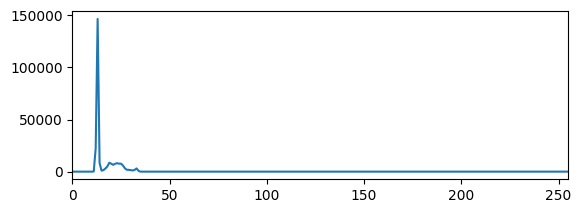

In [31]:
import cv2
from matplotlib import pyplot as plt

first_img = './png_test/img_1.png'
src = cv2.imread(first_img, cv2.IMREAD_GRAYSCALE)
hist = cv2.calcHist([src], [0], None, [256], [0, 255])
plt.subplot(2,1,2),plt.plot(hist)
plt.xlim([0, 255])
plt.show()

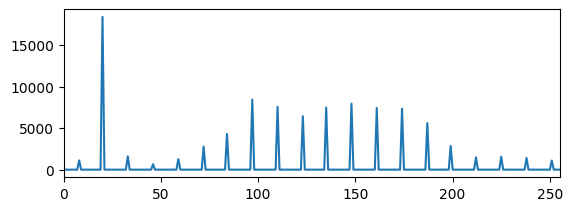

In [32]:
import cv2
from matplotlib import pyplot as plt

first_img = './processed_images/img_1.png'
src = cv2.imread(first_img, cv2.IMREAD_GRAYSCALE)
hist = cv2.calcHist([src], [0], None, [256], [0, 255])
plt.subplot(2,1,2),plt.plot(hist)
plt.xlim([0, 255])
plt.show()

In [40]:
# test 위해서 이미지 키움

img_path = './png_test/img_bright.png'
src = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
dst = cv2.resize(src,(512,512))

cv2.imwrite(img_path, dst)

True